<a href="https://colab.research.google.com/github/Moshood-O/Hamoye-Internship/blob/master/StageE_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a notebook containing the code solutions to the Stage E quiz questions

## Import Necessary Dependencies

In [1]:
# numerical computing and data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# from pylab import rcParams
# rcParams['figure.figsize'] = 15, 8

from sklearn.metrics import mean_squared_error # model evaluation

from fbprophet import Prophet # time series forecasting
from fbprophet.plot import plot_yearly, plot_weekly

import warnings
warnings.filterwarnings("ignore")

**Read the data into a dataframe**

In [2]:
household_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/household_power_consumption.zip (Unzipped Files)/household_power_consumption.txt",
                           sep=";", low_memory=False, header=0, infer_datetime_format=True, parse_dates={"Datetime": ["Date", "Time"]},
                           index_col="Datetime", na_values="?", dtype="float")

household_df.head() # Read the first five rows

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Fill the missing values with the average of their columns

**Check the number of missing values in each columns**

In [3]:
household_df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

**Fill in missing values**

In [4]:
column_averages = household_df.mean() # get the average of each column
household_df.fillna(column_averages, inplace=True) # Fill the missing the values with averages

**Confirm that there are no longer missing values**

In [5]:
household_df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Resample the data from a minute sampling rate to a daily sampling rate

In [6]:
household_df = household_df.resample("D").sum()

household_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


# Question 11
# Visualize a plot of the daily Global_active_power over time

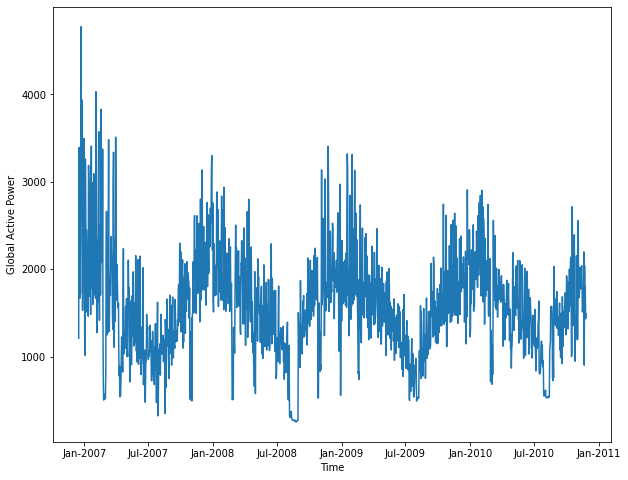

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(household_df.index, household_df.Global_active_power)
ax.set_xlabel("Time")
ax.set_ylabel("Global Active Power")

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

# Question 12
# Get the pearson correlation between the Global_active_power and Global_reactive_power to 2 d.p.

In [8]:
household_df["Global_active_power"].corr(household_df["Global_reactive_power"], method="pearson").round(2)

0.04

**The correlation between global_active_power and global_reactive_power is 0.04**

# Question 13
# Get the pearson correlation between the Voltage and global_intensity to 2 d.p.

In [9]:
household_df["Voltage"].corr(household_df["Global_intensity"], method="pearson").round(2)

0.05

**The correlation between Voltage and global_intensity is 0.05**

## Define helper functions for metric evaluations

In [10]:
def rmse(y_true, y_pred):
    """Evaluate Root-Mean-Squared_Error to 2 d.p."""
    return np.sqrt(mean_squared_error(y_true, y_pred)).round(2)

def mape(y_true, y_pred):
    """Evaluate Mean Absolute Percentage Error to 2 d.p."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.mean(np.abs((y_true - y_pred)/y_true)) * 100).round(2)


# Univariate Time Series Forecasting with the Global_active_power as the target variable

In [11]:
univariate_data = household_df[["Global_active_power"]]
univariate_data.reset_index(inplace=True)
univariate_data.columns = ["ds", "y"]
univariate_data.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


### Split the data into train and test sets using the last 365 days as the latter

In [12]:
train, test = univariate_data.iloc[:-365, :], univariate_data.iloc[-365:, :]
univariate_data.shape, train.shape, test.shape

((1442, 2), (1077, 2), (365, 2))

### Train a time series model using Prophet

In [13]:
univariate_model = Prophet() # create a Prophet model for univariate analysis

univariate_model.fit(train) # train the model

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Make forecast with the model

In [14]:
univariate_forecast = univariate_model.predict(test) # forecast future times with the model
univariate_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1582.602983,1528.030409,2634.031521,1582.602983,1582.602983,518.878164,518.878164,518.878164,-64.106330,-64.106330,-64.106330,582.984494,582.984494,582.984494,0.0,0.0,0.0,2101.481147
1,2009-11-28,1582.737295,1838.171998,2892.502696,1582.737295,1582.737295,822.085199,822.085199,822.085199,245.779609,245.779609,245.779609,576.305590,576.305590,576.305590,0.0,0.0,0.0,2404.822494
2,2009-11-29,1582.871607,1807.017593,2966.479974,1582.871607,1582.871607,796.132932,796.132932,796.132932,228.485697,228.485697,228.485697,567.647235,567.647235,567.647235,0.0,0.0,0.0,2379.004539
3,2009-11-30,1583.005919,1460.006019,2529.769629,1583.005919,1583.005919,396.256682,396.256682,396.256682,-161.258234,-161.258234,-161.258234,557.514916,557.514916,557.514916,0.0,0.0,0.0,1979.262602
4,2009-12-01,1583.140231,1524.599811,2641.359553,1583.140231,1583.140231,517.104170,517.104170,517.104170,-29.330130,-29.330130,-29.330130,546.434300,546.434300,546.434300,0.0,0.0,0.0,2100.244401


## Question 14
## Calculate the Mean Absolute Percentage Error (MAPE) of the model (2 d.p.)

In [15]:
mape(test['y'], univariate_forecast['yhat'])

20.88

**The MAPE of the univariate model is 20.88**

## Question 15
## Calculate the Root Mean Squared Error (RMSE) of the model (2 d.p.)

In [16]:
rmse(test['y'], univariate_forecast['yhat'][-365:])

374.95

**The RMSE of the model is 374.95**

## Question 16
## Plot the components of the forecasted model and determine what month of the yearly seasonality has the lowest value

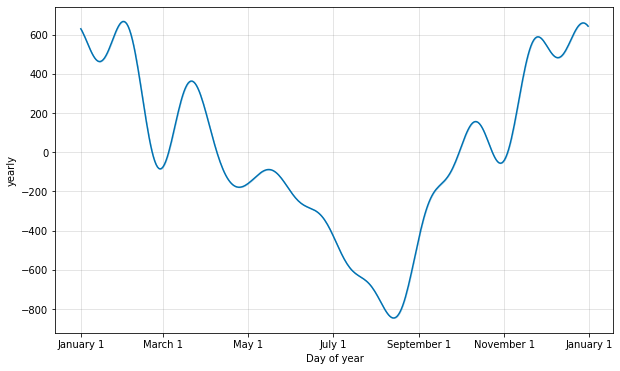

In [17]:
plot_yearly(univariate_model)
plt.show()

**From the plot above, it is seen that the month of AUGUST has the lowest value of yearly seaonality**

# Mutlivariate Time Series Forecasting

In [18]:
multivariate_data = household_df.reset_index()
multivariate_data.rename(columns={"Datetime": "ds", "Global_active_power": "y"}, inplace=True)
multivariate_data.head()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


### Split the data into train and test sets using data from the last 365 days as the test set

In [19]:
train, test = multivariate_data.iloc[:-365, :], multivariate_data.iloc[-365:, :]
multivariate_data.shape, train.shape, test.shape

((1442, 8), (1077, 8), (365, 8))

### Train a multivariate forecasting model

In [20]:
multivariate_model = Prophet(daily_seasonality=True) # create a time series model

# Add the other columns as independent variables (regressors) to the model
for regressor in multivariate_data.columns[2:]:
    multivariate_model.add_regressor(regressor)

multivariate_model.fit(train) # train the model

### Make forecast with the model

In [21]:
multivariate_forecast = multivariate_model.predict(test) # make forecasts with the model
multivariate_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Global_intensity,Global_intensity_lower,Global_intensity_upper,Global_reactive_power,Global_reactive_power_lower,Global_reactive_power_upper,Sub_metering_1,Sub_metering_1_lower,Sub_metering_1_upper,Sub_metering_2,Sub_metering_2_lower,Sub_metering_2_upper,Sub_metering_3,Sub_metering_3_lower,Sub_metering_3_upper,Voltage,Voltage_lower,Voltage_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1310.007394,1365.882505,1397.713852,1310.007394,1310.007394,-232.331927,-232.331927,-232.331927,7.550897,7.550897,7.550897,2.206428,2.206428,2.206428,0.826488,0.826488,0.826488,3.862958,3.862958,3.862958,0.611613,0.611613,0.611613,71.010214,71.010214,71.010214,285.878204,285.878204,285.878204,-217.273544,-217.273544,-217.273544,-0.117448,-0.117448,-0.117448,2.523002,2.523002,2.523002,0.0,0.0,0.0,1381.017608
1,2009-11-28,1310.132803,1846.644782,1878.107618,1310.132803,1310.132803,263.410291,263.410291,263.410291,-8.897769,-8.897769,-8.897769,-2.031750,-2.031750,-2.031750,0.831774,0.831774,0.831774,7.747797,7.747797,7.747797,0.503214,0.503214,0.503214,551.699802,551.699802,551.699802,285.878204,285.878204,285.878204,261.563557,261.563557,261.563557,1.411473,1.411473,1.411473,2.846568,2.846568,2.846568,0.0,0.0,0.0,1861.832605
2,2009-11-29,1310.258212,1626.936246,1660.010660,1310.258212,1310.258212,47.464142,47.464142,47.464142,-2.800951,-2.800951,-2.800951,0.784870,0.784870,0.784870,-0.582363,-0.582363,-0.582363,-1.462280,-1.462280,-1.462280,1.210648,1.210648,1.210648,333.869683,333.869683,333.869683,285.878204,285.878204,285.878204,44.614067,44.614067,44.614067,0.172041,0.172041,0.172041,3.205371,3.205371,3.205371,0.0,0.0,0.0,1644.127895
3,2009-11-30,1310.383621,1725.604228,1759.145884,1310.383621,1310.383621,131.755567,131.755567,131.755567,3.922646,3.922646,3.922646,0.775596,0.775596,0.775596,0.844990,0.844990,0.844990,4.484306,4.484306,4.484306,1.398875,1.398875,1.398875,432.323517,432.323517,432.323517,285.878204,285.878204,285.878204,143.181981,143.181981,143.181981,-0.340705,-0.340705,-0.340705,3.604037,3.604037,3.604037,0.0,0.0,0.0,1742.707137
4,2009-12-01,1310.509029,1747.247952,1778.767652,1310.509029,1310.509029,150.958193,150.958193,150.958193,5.976453,5.976453,5.976453,2.206428,2.206428,2.206428,0.848691,0.848691,0.848691,2.764301,2.764301,2.764301,0.931533,0.931533,0.931533,451.938879,451.938879,451.938879,285.878204,285.878204,285.878204,163.685599,163.685599,163.685599,-1.671302,-1.671302,-1.671302,4.046378,4.046378,4.046378,0.0,0.0,0.0,1762.447909


## Question 17
## Calculate the MAPE of the multivariate time series model (2 d.p.)

In [22]:
mape(test["y"], multivariate_forecast["yhat"])

2.73

**The MAPE of the multivariate model is 2.73**

## Question 18
## Calculate the RMSE of the multivariate time series model (2 d.p)

In [23]:
rmse(test["y"], multivariate_forecast["yhat"])

40.48

**The multivariate model gave an RMSE of 40.48**

## Question 19
## Plot the components of the multivariate forecasted model and determine the day of weekly seasonality with the lowest value

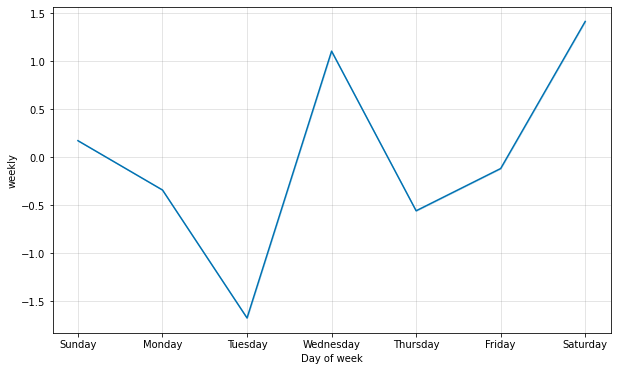

In [24]:
plot_weekly(multivariate_model)
plt.show()

**From the plot above, it is seen that TUESDAY has the lowest value of seasonality.**

# N.B.: It is noteworthy that all of the answers did not tally exactly with the available options in the quiz

# Notebook by: OLALEKE, MOSHOOD A.